In [7]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as backend_pdf
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import gm2
import trfp

sns.set_style('darkgrid')

import helper_function_candidates as helper_old
import analysis_helper as helper

In [2]:
# need a list of "good stations" to use in the averaging to replace data in the affected stations
trolley_moment_df = pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df')


In [3]:
def split_by_nan(input_array):
    return [input_array[clump] for clump in np.ma.clump_unmasked(np.ma.masked_invalid(input_array))]


In [4]:
def trolley_footprint_replacement(moment_df):

    barcode = trfp.STATION_BARCODE_PHI
    nomask_df = moment_df.copy()
    mask_df = nomask_df.copy()
    temp_avg_df = pd.DataFrame(index=mask_df.index)

    veto_extent = 25
    split_station = []
    all_good_stations = np.arange(6,72)  # not using the inflector stations
    no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

    # first need to mask when trolley is near each station
    for st in range(72):
        stms = ['st' + str(st) + ',m' + str(m+1) for m in range(6)]

        veto_low = (barcode[st]-(veto_extent-3)/2)%360
        veto_high = (barcode[st]+3+(veto_extent-3)/2)%360

        if veto_low < veto_high:
            mask = (nomask_df['tr_phi']>veto_low) & (nomask_df['tr_phi']<veto_high)
        else:  # this happens when wrapping around 360 deg
            mask = (nomask_df['tr_phi']>veto_low) | (nomask_df['tr_phi']<veto_high)

        if mask.iloc[0] & mask.iloc[-1]: split_station += [True]
        else: split_station += [False]

        mask_df[stms] = nomask_df[stms].mask(mask)

        # next need to average all good stations that are not within 3 of current station
        if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
            averaging_stations = np.delete(all_good_stations,
                                           np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                      | (np.abs((all_good_stations - st)%72)>=69))
                                          )
        else:
            averaging_stations = np.delete(no_ground_loop_stations,
                                           np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                      | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                          )
        for m in range(6):  # this will need to go over all moments
            stm = 'st' + str(st) + ',m' + str(m+1)
            avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
            temp_avg_df[stm] = nomask_df[avg_stms].mean(axis=1).mask(~mask)

    replaced_df = mask_df.copy()


    # next need to remove the ring wide drift and replace with the station drift
    for st in range(72):
        num_moments = len(trfp.STATION_PROBE_ID[st])
        for m in range(num_moments):
            stm = 'st' + str(st) + ',m' + str(m+1)
            num_endpts = 5
            if not split_station[st]:

                inner_splits = split_by_nan(temp_avg_df[stm].values)
                outer_splits = split_by_nan(mask_df[stm].values)
                first_inner_avg = np.mean(inner_splits[0][0:num_endpts])
                last_inner_avg = np.mean(inner_splits[0][-num_endpts:])
                first_outer_avg = np.mean(outer_splits[0][-num_endpts:])
                last_outer_avg = np.mean(outer_splits[1][0:num_endpts])  # these all use 5 values to make extrapolation easier

                inner_delta_y = 0.5 * (last_inner_avg-first_inner_avg)/inner_splits[0].size * (num_endpts-1)
                outer_delta_y = 0.5 * (last_outer_avg-first_outer_avg)/inner_splits[0].size * (num_endpts-1)
                inner_lin_fit = np.linspace(first_inner_avg-inner_delta_y, last_inner_avg+inner_delta_y, num=inner_splits[0].size)
                outer_lin_fit = np.linspace(first_outer_avg+outer_delta_y, last_outer_avg-outer_delta_y, num=inner_splits[0].size)

                replacement_values = inner_splits[0] - inner_lin_fit + outer_lin_fit
                replaced_df[stm][replaced_df[stm].isna()] = np.array(replacement_values)

            else:

                inner_splits = split_by_nan(temp_avg_df[stm].values)
                first_inner_avg = [np.mean(inner_splits[0][0:num_endpts]), np.mean(inner_splits[1][0:num_endpts])]
                last_inner_avg = [np.mean(inner_splits[0][-num_endpts:]), np.mean(inner_splits[1][-num_endpts:])]
                inner_delta_y = [0.5 * (last_inner_avg[0]-first_inner_avg[0])/inner_splits[0].size * (num_endpts-1),
                                 0.5 * (last_inner_avg[1]-first_inner_avg[1])/inner_splits[1].size * (num_endpts-1)]

                first_inner_fit = np.linspace(first_inner_avg[0]-inner_delta_y[0],
                                              last_inner_avg[0]+inner_delta_y[0],
                                              num=inner_splits[0].size)
                second_inner_fit = np.linspace(first_inner_avg[1]-inner_delta_y[1],
                                              last_inner_avg[1]+inner_delta_y[1],
                                              num=inner_splits[1].size)

                # use 260 seconds of data after (or before) the vetoed window to make a linear fit to approximate "station drift"
                outer_splits = split_by_nan(mask_df[stm].values)
                dt = 1  # the time step, usually 1 sec, but might as well make it a variable
                num_pts = 260//dt  # integer period of 130 sec signal
                first_outer_fit_coeffs = np.polyfit(np.arange(num_pts)*dt, outer_splits[0][0:num_pts], deg=1)
                second_outer_fit_coeffs = np.polyfit(np.arange(num_pts)*dt, outer_splits[0][-num_pts:], deg=1)
                first_outer_fit = np.polyval(first_outer_fit_coeffs,
                                             np.linspace(inner_splits[0].size*-dt, -dt, num=inner_splits[0].size)
                                            )
                second_outer_fit = np.polyval(second_outer_fit_coeffs,
                                              np.linspace(num_pts*dt, (num_pts+inner_splits[0].size)*dt,
                                                          num=inner_splits[1].size)
                                             )

                first_replacement_values = inner_splits[0] - first_inner_fit + first_outer_fit
                second_replacement_values = inner_splits[1] - second_inner_fit + second_outer_fit
                replacement_values = np.append(first_replacement_values, second_replacement_values)
                replaced_df[stm][replaced_df[stm].isna()] = np.array(replacement_values)

    return replaced_df


In [5]:
def trolley_footprint_replacement_2(moment_df, veto_low, veto_high):

    barcode = trfp.STATION_BARCODE_PHI
    nomask_df = moment_df.copy()
    mask_df = nomask_df.copy()
    temp_avg_df = pd.DataFrame(index=mask_df.index)

    split_station = []
    all_good_stations = np.arange(6,72)  # not using the inflector stations
    no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

    # first need to mask when trolley is near each station
    for st in range(72):
        stms = ['st' + str(st) + ',m' + str(m+1) for m in range(6)]

        if veto_low < veto_high:
            mask = (nomask_df['tr_phi']>veto_low) & (nomask_df['tr_phi']<veto_high)
        else:  # this happens when wrapping around 360 deg
            mask = (nomask_df['tr_phi']>veto_low) | (nomask_df['tr_phi']<veto_high)

        if mask.iloc[0] & mask.iloc[-1]: split_station += [True]
        else: split_station += [False]

        mask_df[stms] = nomask_df[stms].mask(mask)

        # next need to average all good stations that are not within 3 of current station
        if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
            averaging_stations = np.delete(all_good_stations,
                                           np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                                      | (np.abs((all_good_stations - st)%72)>=69))
                                          )
        else:
            averaging_stations = np.delete(no_ground_loop_stations,
                                           np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                                      | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                          )
        for m in range(6):  # this will need to go over all moments
            stm = 'st' + str(st) + ',m' + str(m+1)
            avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
            temp_avg_df[stm] = nomask_df[avg_stms].mean(axis=1).mask(~mask)

    replaced_df = mask_df.copy()


    # next need to remove the ring wide drift and replace with the station drift
    for st in range(72):
        num_moments = len(trfp.STATION_PROBE_ID[st])
        for m in range(num_moments):
            stm = 'st' + str(st) + ',m' + str(m+1)
            num_endpts = 5
            if not split_station[st]:

                inner_splits = split_by_nan(temp_avg_df[stm].values)
                outer_splits = split_by_nan(mask_df[stm].values)
                first_inner_avg = np.mean(inner_splits[0][0:num_endpts])
                last_inner_avg = np.mean(inner_splits[0][-num_endpts:])
                first_outer_avg = np.mean(outer_splits[0][-num_endpts:])
                last_outer_avg = np.mean(outer_splits[1][0:num_endpts])  # these all use 5 values to make extrapolation easier

                inner_delta_y = 0.5 * (last_inner_avg-first_inner_avg)/inner_splits[0].size * (num_endpts-1)
                outer_delta_y = 0.5 * (last_outer_avg-first_outer_avg)/inner_splits[0].size * (num_endpts-1)
                inner_lin_fit = np.linspace(first_inner_avg-inner_delta_y, last_inner_avg+inner_delta_y, num=inner_splits[0].size)
                outer_lin_fit = np.linspace(first_outer_avg+outer_delta_y, last_outer_avg-outer_delta_y, num=inner_splits[0].size)

                replacement_values = inner_splits[0] - inner_lin_fit + outer_lin_fit
                replaced_df[stm][replaced_df[stm].isna()] = np.array(replacement_values)

            else:

                inner_splits = split_by_nan(temp_avg_df[stm].values)
                first_inner_avg = [np.mean(inner_splits[0][0:num_endpts]), np.mean(inner_splits[1][0:num_endpts])]
                last_inner_avg = [np.mean(inner_splits[0][-num_endpts:]), np.mean(inner_splits[1][-num_endpts:])]
                inner_delta_y = [0.5 * (last_inner_avg[0]-first_inner_avg[0])/inner_splits[0].size * (num_endpts-1),
                                 0.5 * (last_inner_avg[1]-first_inner_avg[1])/inner_splits[1].size * (num_endpts-1)]

                first_inner_fit = np.linspace(first_inner_avg[0]-inner_delta_y[0],
                                              last_inner_avg[0]+inner_delta_y[0],
                                              num=inner_splits[0].size)
                second_inner_fit = np.linspace(first_inner_avg[1]-inner_delta_y[1],
                                              last_inner_avg[1]+inner_delta_y[1],
                                              num=inner_splits[1].size)

                # use 260 seconds of data after (or before) the vetoed window to make a linear fit to approximate "station drift"
                outer_splits = split_by_nan(mask_df[stm].values)
                dt = 1  # the time step, usually 1 sec, but might as well make it a variable
                num_pts = 260//dt  # integer period of 130 sec signal
                first_outer_fit_coeffs = np.polyfit(np.arange(num_pts)*dt, outer_splits[0][0:num_pts], deg=1)
                second_outer_fit_coeffs = np.polyfit(np.arange(num_pts)*dt, outer_splits[0][-num_pts:], deg=1)
                first_outer_fit = np.polyval(first_outer_fit_coeffs,
                                             np.linspace(inner_splits[0].size*-dt, -dt, num=inner_splits[0].size)
                                            )
                second_outer_fit = np.polyval(second_outer_fit_coeffs,
                                              np.linspace(num_pts*dt, (num_pts+inner_splits[0].size)*dt,
                                                          num=inner_splits[1].size)
                                             )

                first_replacement_values = inner_splits[0] - first_inner_fit + first_outer_fit
                second_replacement_values = inner_splits[1] - second_inner_fit + second_outer_fit
                replacement_values = np.append(first_replacement_values, second_replacement_values)
                replaced_df[stm][replaced_df[stm].isna()] = np.array(replacement_values)

    return replaced_df


In [6]:
def trolley_run_station_average_2(input_df, low, high):
    station_phi = trfp.STATION_BARCODE_PHI
    corrected_df = input_df.copy()
    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.empty([72,17])
    fp_baseline = np.empty([72,6])
    summed_azimuth = np.empty(72)
    summed_pts = np.empty(72)
    baseline_time = np.empty(72)
    tr_baseline[:] = np.nan
    fp_baseline[:] = np.nan
    summed_azimuth[:] = np.nan
    summed_pts[:] = np.nan
    baseline_time[:] = np.nan

    for st in range(72): 
        if high > low:
            mask = (corrected_df['tr_phi'] >= low) & (corrected_df['tr_phi'] < high)
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= low) | (corrected_df['tr_phi'] < high)

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)        
        baseline_time[st] = sum(out_df.index.values)/summed_pts[st]

        for m in range(17):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, summed_pts

In [12]:
lows = range(0,70,10) + range(100,360,10)
m0_diffs = np.zeros((len(lows),72))

print lows

[0, 10, 20, 30, 40, 50, 60, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350]


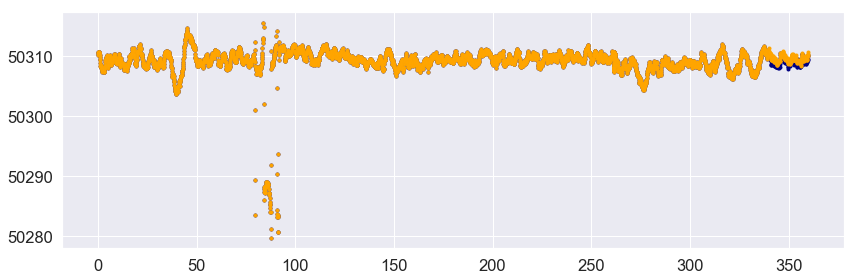

In [13]:
ii=0

for low in lows:
    high = low+5

    replaced_1 = trolley_footprint_replacement(trolley_moment_df)
    replaced_2 = trolley_footprint_replacement_2(replaced_1.copy(), low-10,high+10)

    tr_baseline1, fp_baseline1, _, _, _ = trolley_run_station_average_2(replaced_1, low, high)
    tr_baseline2, fp_baseline2, _, _, _ = trolley_run_station_average_2(replaced_2, low, high)

    m0_diff = fp_baseline2[:,0] - fp_baseline1[:,0]
    m0_diff[[1,3,5]] = np.nan

    m0_diffs[ii,:] = m0_diff
    
    ii += 1

fig, ax = plt.subplots(1,1)
plt.sca(ax)
plt.plot(replaced_1['tr_phi'], replaced_1['st30,m1'], '.', color='navy')
plt.plot(replaced_2['tr_phi'], replaced_2['st30,m1'], '.', color='orange')
fig.set_size_inches(12,4)
fig.tight_layout()

0.2668157822030812
0.8481502438923076


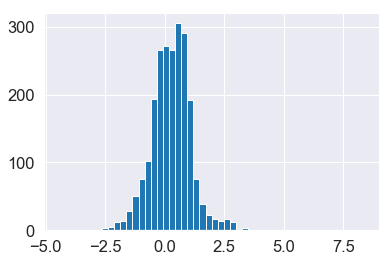

In [28]:
hist = m0_diffs.flatten()
print np.mean(hist[~np.isnan(hist)])
print np.std(hist[~np.isnan(hist)])

_ = plt.hist(hist[~np.isnan(hist)], bins=50)

In [9]:
print m0_means*16.
print m0_stds*16

print np.mean(m0_means)*16
print np.std(m0_means)*16
print np.mean(m0_stds)*16

[ -1.30934185   8.01677807  -7.0527558   -6.26752818  -7.98840845
 -14.9700967   15.05811229  33.9184343    8.89590325   1.17689796
  21.30490397   9.81410621   6.56594313   7.40710929  -1.20021261
  -3.75024097  -7.75877779   3.8609164   10.07776121 -12.34196269
  -7.17244419 -10.11470641   9.46625706 -20.97569844  15.14219154
   2.01676732   5.86229151  22.42930723   7.76657734   6.82123747
  14.46956761  16.62094838   6.46326583]
[19.03171794 12.1137977  40.39380914 18.42010205 26.41450608 11.0357212
 11.0072334  24.85902712 32.72560719 41.68228558 34.91346277 20.67576849
 22.07836162 14.4302984  14.99426684 20.33324772 33.68297485 17.47813009
 17.60632804 47.03377129 20.98533526 48.32497039 19.60887849 22.78084588
 12.95157475 14.14620508 29.19080525 55.62886266 65.84163857 61.65944257
 15.5729667  31.3426338  18.07736082]
4.007669796169175
11.614642057434818
27.182482962459794


In [ ]:

# print tr_baseline1

In [ ]:
fig, axs = plt.subplots(2,1)
plt.sca(axs[0])
plt.plot(replaced_1['tr_phi'], replaced_1['st30,m1'],'.')
plt.sca(axs[1])
plt.plot(replaced_2['tr_phi'], replaced_2['st30,m1'],'.')

fig.set_size_inches(12,12)
fig.tight_layout()

In [ ]:
# pdf = backend_pdf.PdfPages("new_trolley_footprint_replacement_m1_time.pdf")

m = 0

# x = nomask_df['tr_phi']
x = mask_df.index.values

fig,ax=plt.subplots(4,1)

for st in range(72):
    
    for axis in ax:
        plt.sca(axis)
        plt.cla()

    plt.sca(ax[0])
    plt.plot(x, nomask_df['st'+str(st)+',m'+str(m+1)], '.')
    plt.sca(ax[1])
    plt.plot(x, mask_df['st'+str(st)+',m'+str(m+1)], '.')
    # plt.plot(x_edges, [first_outer_avg, last_outer_avg], '.', color='orange', markersize=10)
    plt.sca(ax[2])
    plt.plot(x, temp_avg_df['st'+str(st)+',m'+str(m+1)], '.')
    # plt.plot(x_edges, [first_inner_avg, last_inner_avg], '.', color='orange', markersize=10)
    plt.sca(ax[3])
    plt.plot(x, replaced_df['st'+str(st)+',m'+str(m+1)], '.')

    for axis in ax:
        axis.set_xlim((np.min(x),np.max(x)))

    ax[0].set_title('station ' + str(st) + ', m' + str(m) + ' raw data')
    ax[1].set_title('vetoed window')
    ax[2].set_title('replacement data from ring avg')
    ax[3].set_title('replacement complete')

    fig.set_size_inches(12, 12)
    fig.tight_layout()
    
#     pdf.savefig(fig, dpi=70)

pdf.close()
